In [ ]:
#hide
from utils import *

# Collaborative filtering deep dive

## Introduction to collaborative filtering

In [ ]:
from fastai2.collab import *
from fastai2.tabular.all import *
path = untar_data(URLs.ML_100k)

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
last_skywalker = np.array([0.98,0.9,-0.9])

In [ ]:
user1 = np.array([0.9,0.8,-0.6])

In [ ]:
(user1*last_skywalker).sum()

2.1420000000000003

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
(user1*casablanca).sum()

-1.611

## Learning the latent factors

## Creating the DataLoaders

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,332,Jaws 2 (1978),4
1,343,Jurassic Park (1993),5
2,624,Trainspotting (1996),4
3,887,Schindler's List (1993),5
4,19,Liar Liar (1997),3
5,907,Nell (1994),5
6,237,"Boys of St. Vincent, The (1993)",5
7,683,Apt Pupil (1998),4
8,243,"Piano, The (1993)",5
9,71,"Silence of the Lambs, The (1991)",4


In [ ]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [ ]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [ ]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

## Collaborative filtering from scratch

In [ ]:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [ ]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [ ]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.309138,1.299825,00:15
1,1.102525,1.121799,00:15
2,0.967625,0.993044,00:15
3,0.824581,0.901068,00:15
4,0.796305,0.884824,00:15


In [ ]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.982041,0.988120,00:16
1,0.879609,0.903623,00:16
2,0.671048,0.866238,00:16
3,0.485887,0.874471,00:15
4,0.362418,0.878503,00:15


In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.945770,0.936150,00:22
1,0.824700,0.866173,00:22
2,0.589560,0.866441,00:23
3,0.408351,0.893146,00:22
4,0.284422,0.900390,00:22


### Weight decay

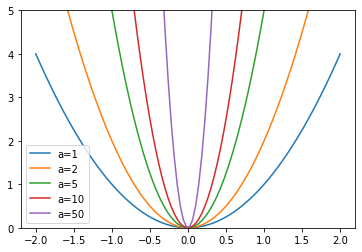

In [ ]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots()
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.935149,0.957065,00:22
1,0.859534,0.872719,00:22
2,0.734857,0.832345,00:23
3,0.600854,0.820575,00:23
4,0.500854,0.820172,00:23


## Interpreting embeddings and biases

In [ ]:
movie_bias = learn.model.movie_bias.weight.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Home Alone 3 (1997)',
 'Robocop 3 (1993)',
 'Beautician and the Beast, The (1997)']

In [ ]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)",
 'Titanic (1997)']

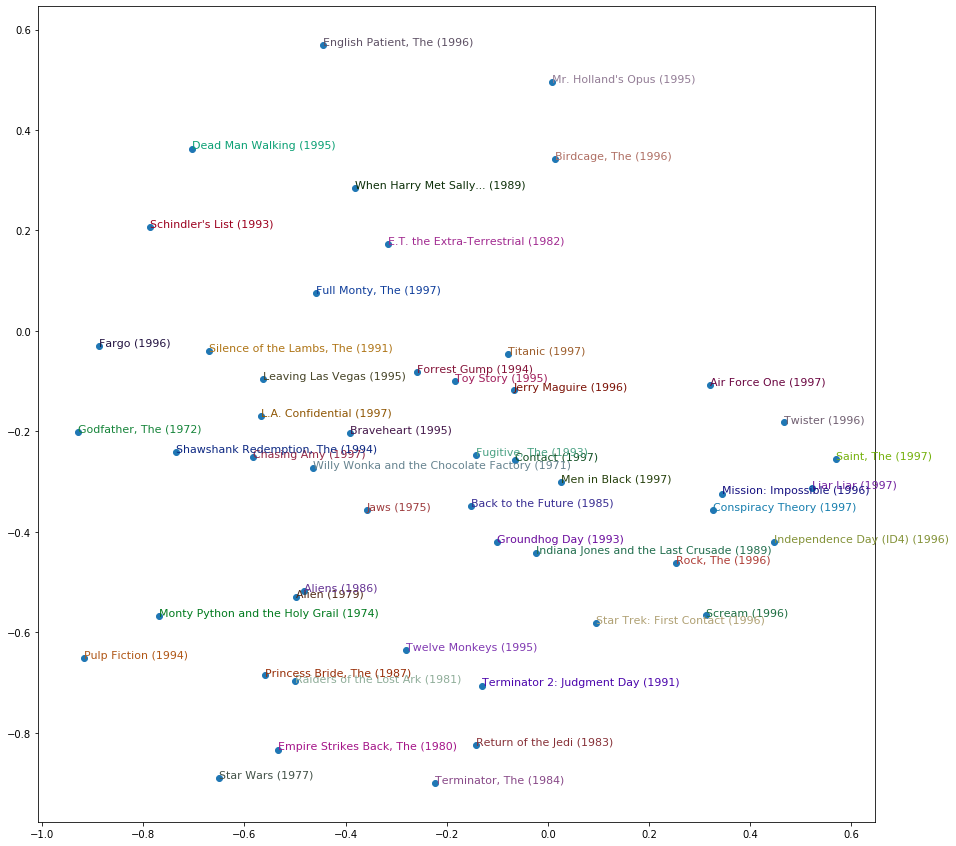

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Embedding distance

In [ ]:
movie_factors = learn.model.movie_factors.weight
la_idx = dls.classes['title'].o2i['L.A. Confidential (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[la_idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'

## Boot strapping a collaborative filtering model

## Using fastai.collab

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950121,0.955827,00:16
1,0.860315,0.877788,00:16
2,0.728865,0.842400,00:16
3,0.594641,0.824307,00:16
4,0.499862,0.825145,00:16


## Deep learning for collaborative filtering

In [ ]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)
        
    def forward(self, x): return super().forward(x, None)

### Sidebar: kwargs and delegates

### End sidebar

In [ ]:
embs = get_emb_sz(dls, {'user':50, 'title':50})
embs

[(944, 50), (1635, 50)]

In [ ]:
model = EmbeddingNN(embs, layers=[100], y_range=(0,5.5))

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.965729,0.990180,00:25
1,0.898545,0.914952,00:24
2,0.874419,0.888544,00:24
3,0.817418,0.871285,00:24
4,0.761706,0.877536,00:24
